In [1]:
# For preprocessing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import emoji
from urllib.parse import urlparse

# For VaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# For RNN model 
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# For DistilBERT
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# 1. Data Preprocessing

In [2]:
train_df = pd.read_parquet('datasets/btc_tweets_train.parquet.gzip')
test_df = pd.read_parquet('datasets/btc_tweets_test.parquet.gzip')

In [3]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [4]:
def df_info(df):
    return df.shape, df.isnull().sum().sum(), df.info(), df.head()

df_info(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          1500 non-null   int64 
 1   hashtags          1500 non-null   object
 2   content           1500 non-null   object
 3   username          1500 non-null   object
 4   user_displayname  1500 non-null   object
 5   sentiment         1500 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 60.2+ KB


((1500, 6),
 0,
 None,
               tweet ID                                           hashtags  \
 0  1641579121972236290  [Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...   
 1  1641579176171016194                 [Bitcoin, bitcoinordinals, crypto]   
 2  1641579486071390208  [BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...   
 3  1641579537103302656                                              [BTC]   
 4  1641579588399804418                                          [Bitcoin]   
 
                                              content      username  \
 0  $Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...   BezosCrypto   
 1  Alright I have my rares. Who else is grabbing ...   spartantc81   
 2  Bitcoin (BTC) Targets Over $100,000 as This Im...   BezosCrypto   
 3  📢 Xverse Web-based pool is live:\n\n•Update @x...  godfred_xcuz   
 4  Yesterday, a Bitcoin projection was displayed ...   goddess81oo   
 
   user_displayname  sentiment  
 0       SHIB Bezos       True  
 1        Spa

In [5]:
train_df = train_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)
test_df = test_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)

In [6]:
# Converting the sentiment labels from bool to int
train_df['sentiment'] = train_df['sentiment'].astype(int)
test_df['sentiment'] = test_df['sentiment'].astype(int)

In [7]:
class DataPreprocessor:
    def __init__(self):
        """
        Initialize the DataPreprocessor class.
        
        Args commonly used in the Methods defined below:
        
        - df (pd.DataFrame): The DataFrame containing the dataset.
        
        - content_column (str): The name of the column containing the text content to analyze.
        
        - sentiment_column (str): The name of the column containing the sentiment labels.
            
        (other Args specific to defined methods are explained in that method's docstring)
        """
    
    def remove_spam_content(self, df, content_column, similarity_threshold=0.65):
        """
        Removes extremly similar samples using cosine similarity.
        
        Args:
        - similarity_threshold (float): (default=0.65) The threshold for cosine similarity above which samples are considered similar.
        """
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(df[content_column])
        cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        indices_to_remove = set()

        for i in range(len(cosine_sim)):
            for j in range(i + 1, len(cosine_sim)):
                if cosine_sim[i, j] > similarity_threshold:
                    indices_to_remove.add(i)
                    indices_to_remove.add(j)

        df = df.drop(index=indices_to_remove).reset_index(drop=True)
        return df

    def remove_hashtags(self, df, content_column, top_n=30):
        """
        Remove non-whitelisted hashtags from the tweet.
        
        Args:
        - top_n (int): Retain top n number of hashtags and remove others from the tweets.
        """
        
        def extract_hashtags(tweet):
            """Extract all hashtags from the text."""
            return re.findall(r'#\w+', tweet)
        
        def create_hashtag_whitelist(top_n):
            """Create a whitelist of the top N most frequent hashtags."""
            # Extract all hashtags from the dataset
            all_hashtags = sum(df[content_column].apply(extract_hashtags), [])
            # Count the occurrences of each hashtag
            hashtag_counts = Counter(all_hashtags)
            # Get the top N hashtags
            top_hashtags = [hashtag for hashtag, count in hashtag_counts.most_common(top_n)]
            return top_hashtags
        
        # Create the whitelist of top N hashtags
        whitelist = create_hashtag_whitelist(top_n=top_n)
        
        def clean_hashtags(tweet):
            hashtags = extract_hashtags(tweet)
            # Retain only hashtags in the whitelist
            for hashtag in hashtags:
                if hashtag not in whitelist:
                    tweet = tweet.replace(hashtag, '')
            return tweet
        
        # Apply the cleaning function to the dataframe
        df['hashtag_removed'] = df[content_column].apply(clean_hashtags)
        return df
    
    def remove_link(self, df, content_column):
        """
        Removes the links from the tweet
        """
        def remove_links(tweet):
            return re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
        df['links_removed'] = df[content_column].apply(remove_links)
        return df
    
    def remove_whitespace_html(self, df, content_column):
        """
        Removes unnecessary whitespace and html markups from the text
        """
        def remove_whitesp(tweet):
            tweet = BeautifulSoup(tweet, 'html.parser').get_text()
            tweet = ' '.join(tweet.split())
            return tweet
        df['whitespace_html_removed'] = df[content_column].apply(remove_whitesp)
        return df

    def clean_text(self, df, content_column):
        """
        Cleans text data by removing punctuation, stopwords, and applying lemmatization.
        """
        nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))

        def clean(tweet):
             # Remove links
            tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
            # Convert emojis to text # Converts emojis to text, e.g., "😊" becomes ":smiling_face:"
            tweet = emoji.demojize(tweet, delimiters=(" ", " "))
            # Removes unnecessary whitespace and html markups from the text
            tweet = BeautifulSoup(tweet, 'html.parser').get_text()
            tweet = ' '.join(tweet.split())
            # Remove punctuation and numbers
            tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
            # Tokenize
            words = nltk.word_tokenize(tweet)
            # Remove stop words
            words = [word for word in words if word.lower() not in stop_words]
            # Lemmatize words
            lemmatizer = nltk.WordNetLemmatizer()
            words = [lemmatizer.lemmatize(word.lower()) for word in words]
            return ' '.join(words)
        
        df['cleaned_content'] = df[content_column].apply(clean)
        return df
    
    def handle_class_imbalance_with_SMOTE(self):
        """
        Handles class imbalance using SMOTE (Synthetic Minority Over-sampling Technique).
        """
        
        tfidf = TfidfVectorizer(stop_words='english')
        X = tfidf.fit_transform(self.df[self.content_column])
        y = self.df[self.sentiment_column]
        
        # Apply SMOTE to the vectorized text
        smote = SMOTE(random_state=21)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        self.df = pd.DataFrame(X_resampled.toarray(), columns=tfidf.get_feature_names_out())
        self.df[self.sentiment_column] = y_resampled
        return self.df

In [8]:
datapreprocessor = DataPreprocessor()

**NOTE: both the cleaned datasets above are still imbalanced with True values largly outnumbered than False. The imbalance needs to be taken care of by assigning class weights dring model training.**

# 2. Benchmark: vaderSentiment Sentiment Dictionary

For sentiment analysis specifically using VADER, it's best to apply VADER to the raw, uncleaned text to leverage its strengths in handling informal language, punctuation, and emojis. However, when it comes to Links, it is best to remove them. Links are irrelevent to the sentiment and could add unnecessary noise, potentially influencing the sentiment.

The preprocessing flow for vaderSentiment
- Remove spam tweets
- Remove links
- Remove unnecessary hashtags
- Then apply vader sentiment dictionary on the cleaned tweets

### 2.1. Getting the dataset ready for VaderSentiment

In [ ]:
# Asign a 
vader_test_df = train_df.copy()

In [ ]:
# Remove spam and bot samples
vader_test_df = datapreprocessor.remove_spam_content(df=vader_test_df, content_column='content')

In [ ]:
# Remove links from the tweets
vader_test_df = datapreprocessor.remove_link(df=vader_test_df, content_column='content')

In [ ]:
# Remove unnecessary hashtags from the tweets
vader_test_df = datapreprocessor.remove_hashtags(df=vader_test_df, content_column='links_removed', top_n = 25)

In [ ]:
vader_test_df = datapreprocessor.remove_whitespace_html(df=vader_test_df, content_column='hashtag_removed')

In [ ]:
vader_test_df.head()

In [ ]:
# look over on example to see if the links have been removed
index = 4
vader_test_df['content'].iloc[index], vader_test_df['links_removed'].iloc[index], vader_test_df['hashtag_removed'].iloc[index], vader_test_df['whitespace_html_removed'].iloc[index]

### 2.2. Fitting the VaderSentiment on processed data

In [ ]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis and get the compound score
def get_sentiment_score(text):
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']  # 'compound' score is a normalized score between -1 (negative) and +1 (positive)

# Apply sentiment analysis to the 'content' column and create a new column for the sentiment score
vader_test_df['vader_sentiment'] = vader_test_df['whitespace_html_removed'].apply(get_sentiment_score)

# Optional: Classify the sentiment based on the compound score
def classify_sentiment(score):
    if score >= -0.03:
        return True
    else:
        return False

# Apply the classification and create a new column for the sentiment label
vader_test_df['vader_sentiment_label'] = vader_test_df['vader_sentiment'].apply(classify_sentiment)


In [ ]:
#vader_test_df.head()

### 2.3. Evaluating the vaderSentiment classification performance

In [ ]:
y_true = vader_test_df['sentiment']
y_pred = vader_test_df['vader_sentiment_label']

# Generate classification report
print('Classification report:\n')
print(classification_report(y_true, y_pred))

# Generate a confusion matrix
vader_conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(vader_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive(1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrx')
plt.show()

# 3. RNN 

### 3.1. Getting the dataset ready for generating the embeddings

In [9]:
# Remove spam samples
unspammed_train_df = datapreprocessor.remove_spam_content(df=train_df, content_column='content')
unspammed_test_df = datapreprocessor.remove_spam_content(df=test_df, content_column='content')

In [10]:
# Remove unnecessary hashtags
unhashtag_train_df = datapreprocessor.remove_hashtags(df=unspammed_train_df, content_column='content')
unhashtag_test_df = datapreprocessor.remove_hashtags(df=unspammed_test_df, content_column='content')

In [ ]:
# Cleaned tweets (Free from links, emojis, whitespace, html markup and then Lemmetized)
cleaned_train_df = datapreprocessor.clean_text(df=unhashtag_train_df, content_column='hashtag_removed')
cleaned_test_df = datapreprocessor.clean_text(df=unhashtag_test_df, content_column='hashtag_removed')

### 3.2. Training the FastText embeddings

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# Tokenize the cleaned tweets (split by spaces)
tokenized_tweets = [tweet.split() for tweet in cleaned_train_df['cleaned_content']]

# Train FastText model using Gensim's implementation
fasttext_model = FastText(sentences=tokenized_tweets, vector_size=75, window=5, min_count=1, sg=1, epochs=10)

# Save the model
#fasttext_model.save("fasttext_vs50.model")

# Load the model (for future use)
#fasttext_model = FastText.load("fasttext_vs50.model")

In [ ]:
# Example: Get vector for a word 
# print(f"Vector for 'bitcoin': {fasttext_model.wv['bitcoin']}")

# Example: Get most similar words
#print(f"Words similar to 'bitcoin': {fasttext_model.wv.most_similar('bitcoin')}")

### 3.3. Building and Training the RNN model

In [ ]:
# Parameters
max_sequence_length = 40
embedding_dim = 75
embedding_matrix = fasttext_model.wv.vectors # Create embedding matrix
vocab_size = len(fasttext_model.wv) #len(tokenizer.word_index)+1

In [ ]:
#fasttext_model.wv.vector_size, len(tokenizer.word_counts), vocab_size, tokenizer.word_index.items()

In [ ]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(cleaned_train_df['cleaned_content'])

train_sequences = tokenizer.texts_to_sequences(cleaned_train_df['cleaned_content']) # sequences are arrays where the each word is replaced by number which corresponds to the position of that word in the vocabulary
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(cleaned_test_df['cleaned_content'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [ ]:
# Dimension check
padded_train_sequences.shape, cleaned_train_df['sentiment'].shape

In [ ]:
# Split the data to training and validation
X_train, X_val, y_train, y_val = train_test_split(padded_train_sequences, cleaned_train_df['sentiment'], test_size = 0.2, random_state = 9)
# Changing the dtype from series to array
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Preparing the test data
X_test = padded_test_sequences
y_test = cleaned_test_df['sentiment'].to_numpy()

In [ ]:
# Calculate the class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

Study about kernel_regularizer, learning_rate

In [ ]:
# Build the RNN model
def build_rnn_model(embd_dim, rnn_type='LSTM'):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    model.add(Embedding(input_dim = vocab_size, 
                        output_dim = embd_dim, 
                        weights=[embedding_matrix],  
                        trainable=False))
    
    if rnn_type == 'LSTM':
        model.add(LSTM(units = 128, return_sequences = False))
    elif rnn_type == 'GRU':
        model.add(GRU(units = 128, return_sequences= False))
        
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.02)))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Initialize the model
model = build_rnn_model(embd_dim=embedding_dim, rnn_type='LSTM')
model.summary()

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping])

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

In [ ]:
# Predicting sentiments on new tweets
predictions = model.predict(X_test)
# Convert probabilities to binary predictions
#predictions = (predictions > 0.612).astype(int)  

In [ ]:
y_test, predictions.flatten()

In [ ]:
predictions.max()-predictions.min()

In [ ]:
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

# 4. Pre-trained DistilBERT

In [ ]:
bert_cleaned_train_df.head()

In [11]:
bert_cleaned_train_df = datapreprocessor.remove_link(df=unhashtag_train_df, content_column='hashtag_removed')
bert_cleaned_train_df = datapreprocessor.remove_whitespace_html(df=bert_cleaned_train_df,content_column='links_removed')

C:\Users\Diya\AppData\Local\Temp\ipykernel_25688\945314507.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [12]:
bert_cleaned_test_df = datapreprocessor.remove_link(df=unhashtag_test_df, content_column='hashtag_removed')
bert_cleaned_test_df = datapreprocessor.remove_whitespace_html(df=bert_cleaned_test_df,content_column='links_removed')

C:\Users\Diya\AppData\Local\Temp\ipykernel_25688\945314507.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [13]:
# Dataset Preparation for Handling Tweet Data
class TweetDataset:
    def __init__(self, texts, labels=None, tokenizer=None, max_len=40):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    # Tokenize the text samples and prepares them for input into the model.
    def encode(self):
        encodings = self.tokenizer(
            self.texts,
            truncation=True,
            padding=True,
            max_length=self.max_len,
            return_tensors='tf'
        )
        return encodings
    
    # Converts the tokenized texts and labels into a TensorFlow Dataset object.
    def prepare_data(self):
        encodings = self.encode()
        if self.labels is not None:
            dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), self.labels))
        else:
            dataset = tf.data.Dataset.from_tensor_slices(dict(encodings))
        return dataset

In [14]:
# Class to Fit Pretrained DistilBERT and Fine-Tune It
class SentimentAnalyzer:
    def __init__(self, model_name='distilbert-base-uncased', num_labels=2):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    def fit_pretrained(self, test_texts, batch_size=16):
        test_dataset = TweetDataset(texts=test_texts, tokenizer=self.tokenizer).prepare_data()
        test_dataset = test_dataset.batch(batch_size)

        predictions = self.model.predict(test_dataset).logits
        predictions = tf.argmax(predictions, axis=-1).numpy()

        return predictions

    def fine_tune(self, train_texts, train_labels, test_texts, test_labels, batch_size=16, epochs=3):
        train_dataset = TweetDataset(texts=train_texts, labels=train_labels, tokenizer=self.tokenizer).prepare_data()
        test_dataset = TweetDataset(texts=test_texts, labels=test_labels, tokenizer=self.tokenizer).prepare_data()

        train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
        test_dataset = test_dataset.batch(batch_size)
        
        # Assuming train_labels is your array of labels
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        class_weight_dict = dict(enumerate(class_weights))

        #optimizer = Adam(learning_rate=5e-5)
        self.model.compile(optimizer='adam', 
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #self.model.compute_loss, 
                           metrics=['accuracy'])

        history = self.model.fit(
            train_dataset,
            validation_data=test_dataset,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict
        )

        return history

In [15]:
train_texts = bert_cleaned_train_df['whitespace_html_removed'].tolist()
train_labels = bert_cleaned_train_df['sentiment'].tolist()
test_texts = bert_cleaned_test_df['whitespace_html_removed'].tolist()
test_labels = bert_cleaned_test_df['sentiment'].tolist()

In [16]:
# Initialize the SentimentAnalyzer
sentiment_analyzer = SentimentAnalyzer()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### Pretrained predictions


In [17]:
# Fit Pretrained DistilBERT on Test Dataset
pretrained_predictions = sentiment_analyzer.fit_pretrained(test_texts=test_texts)

30/30 [==============================] - 13s 299ms/step


In [18]:
# Class to Evaluate the Model's Performance
class PerformanceEvaluator:
    def __init__(self):
        pass

    def evaluate(self, true_labels, predicted_labels):
        print('Classification report:\n')
        return print(classification_report(true_labels, predicted_labels))

    def plot_confusion_matrix(self, true_labels, predicted_labels):
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(6, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive(1)'], yticklabels=['Negative (0)', 'Positive(1)'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.80      1.00      0.89       379

    accuracy                           0.80       475
   macro avg       0.40      0.50      0.44       475
weighted avg       0.64      0.80      0.71       475



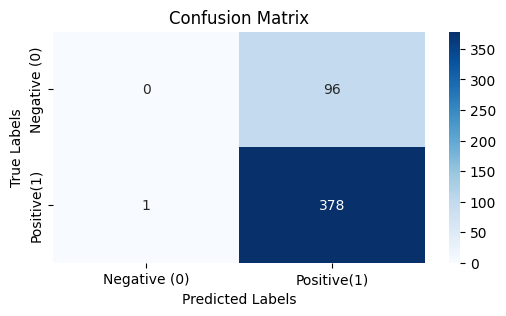

In [19]:
# Initialize PerformanceEvaluator
evaluator = PerformanceEvaluator()
evaluator.evaluate(true_labels=test_labels, predicted_labels=pretrained_predictions)
evaluator.plot_confusion_matrix(true_labels=test_labels, predicted_labels=pretrained_predictions)

In [ ]:
np.unique(test_labels, return_counts=True)

In [ ]:
np.unique(pretrained_predictions, return_counts=True)

### Fine tuned predictions

In [20]:
# Fine tune on train dataset and apply on test dataset
sentiment_analyzer.fine_tune(train_texts, train_labels, test_texts, test_labels)


Epoch 1/3


88/88 [==============================] - 139s 1s/step - loss: 0.5820 - accuracy: 0.7898 - val_loss: 0.5139 - val_accuracy: 0.7979
Epoch 2/3
88/88 [==============================] - 125s 1s/step - loss: 0.5301 - accuracy: 0.8041 - val_loss: 0.5125 - val_accuracy: 0.7979
Epoch 3/3
88/88 [==============================] - 125s 1s/step - loss: 0.5295 - accuracy: 0.8041 - val_loss: 0.5034 - val_accuracy: 0.7979


In [21]:
fine_tuned_predictions = sentiment_analyzer.fit_pretrained(test_texts)

30/30 [==============================] - 9s 252ms/step


In [22]:
fine_tuned_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.80      1.00      0.89       379

    accuracy                           0.80       475
   macro avg       0.40      0.50      0.44       475
weighted avg       0.64      0.80      0.71       475



c:\Users\Diya\anaconda3\envs\DELTA\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diya\anaconda3\envs\DELTA\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diya\anaconda3\envs\DELTA\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


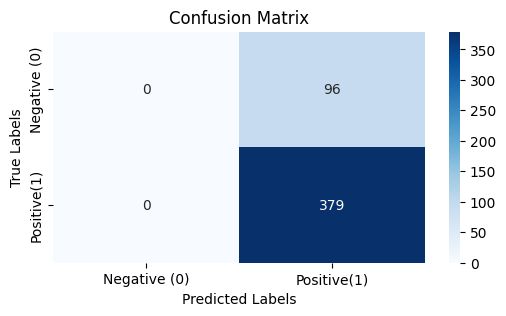

In [23]:
evaluator.evaluate(true_labels=test_labels, predicted_labels=fine_tuned_predictions)
evaluator.plot_confusion_matrix(true_labels=test_labels, predicted_labels=fine_tuned_predictions)

In [ ]:
print(tf.__version__)

In [ ]:
import transformers
print(transformers.__version__)

In [ ]:
classifier = pipeline('sentiment-analysis')

In [ ]:
res = classifier(cleaned_train_df['content'][3])

In [ ]:
print(res)

In [ ]:
cleaned_train_df['content'][3]

In [ ]:
cleaned_train_df['sentiment'][3]

In [ ]:
cleaned_test_df['sentiment'].value_counts()

In [ ]:
len(X_train[0])

In [ ]:
invalid_roe = [index for index, row in enumerate(X_val) if len(row) > 50]

print(invalid_roe)

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token=1)
# The oov_token is a placeholder token that replaces any OOV words during the text_to_sequence calls.
#This ensures that your model can handle new, unseen words gracefully.
tokenizer.fit_on_texts(X_train)

In [ ]:
# On how many tweets did we train?
print(tokenizer.document_count)

In [ ]:
# How many unique words?
len(tokenizer.word_counts)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [ ]:
# Pad the sequences
max_length = 28  # Set max length for padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

In [ ]:
import numpy as np

# Create an embedding matrix
embedding_dim = 100  # Must match the dimension of FastText vectors
vocab_size = len(tokenizer.word_index) + 1   #it's the total number of unique words in your tokenizer’s vocabulary plus one. The +1 accounts for the padding token (index 0).
embedding_matrix = np.zeros((vocab_size, embedding_dim)) #embedding_matrix is initialized as a matrix of zeros with shape (vocab_size, embedding_dim). 
                                                        #This matrix will eventually hold the FastText vectors for each word in your vocabulary.

for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

In [ ]:
embedding_matrix

### RNN Model

In [ ]:
#import keras as kp

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_length, 
                    trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
import gensim
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Assuming 'contents' is the column with the tweets and 'sentiment' is the label (0 or 1)
texts = cleaned_train_df['cleaned_contents'].astype(str).tolist() 
labels = cleaned_train_df['sentiment'].values

# Load pre-trained FastText embeddings
fasttext.util.download_model('en', if_exists='ignore')  # Download the model if not already present
ft = fasttext.load_model('cc.en.300.bin')  # Load the pre-trained FastText model

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences to ensure uniform input length
max_sequence_length = 50  # You can adjust this based on your data
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Create an embedding matrix using the FastText embeddings
embedding_dim = 300  # FastText embeddings typically have 300 dimensions
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = ft.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_length, 
                    trainable=False))  # Set trainable to False to keep FastText embeddings static
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=32, 
          validation_data=(X_val, y_val), 
          class_weight=class_weights_dict)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

